# Test 4 : compare pre-graphs
In this notebook, we compare, for GCN model with euclidean distance, the possible pre-graphs : fully connected, tumour type, KMeans, Spectral clustering, and Hierarchical clustering. We use the whole dataset with mutational signatures, all normalized.

## Table of contents

1. [Fully connected pre-graph](#1-fully-connected)
2. [Tumour type pre-graph](#2-pre-graph)
3. [KMeans pre-graph](#3-kmeans)
4. [Evaluate performances for each pre-graph](#4-performances)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from evaluation.ClassificationMetrics import ClassificationMetrics

from manage.GCNClassifierTrainTestManager import GCNClassifierTrainTestManager

from models.GCNClassifier import GCNClassifier

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from utils.preProcessing import preProcessing

## 0. Reading dataset and preprocessing

In [2]:
# Reading
df = pd.read_excel('data/table-s1-sigmut-indel.xlsx')

# Drop non naive patients
df = df.loc[df["Cohort"] == "Naive"]

# Drop NaN values
df = preProcessing.delete_nan_values(df)

# Re-label patients
t = 183
df = preProcessing.relabel_patients(df, "Progression_1","Time to progression (days)",t)

# Select features
features_name = ["Age at advanced disease diagnosis","CD8+ T cell score","Genome mut per mb","Exome mut per mb","CD274 expression","M1M2 expression","SBS1","SBS2","SBS3","SBS4","SBS5","SBS7a","SBS7b","SBS7c","SBS7d","SBS8","SBS10a","SBS10b","SBS10c","SBS13","SBS15","SBS17a","SBS17b","SBS18","SBS31","SBS35","SBS36","SBS37","SBS38","SBS40","SBS44","SBS4426","ID1","ID2","ID3","ID4","ID5","ID6","ID7","ID8","ID9","ID10","ID11","ID12","ID13","ID14","ID15","ID16","ID17","ID18"]
features_to_normalize = ["Age at advanced disease diagnosis","CD8+ T cell score","Genome mut per mb","Exome mut per mb","CD274 expression","M1M2 expression"]

# Normalize features except mutational signatures
df.loc[:,features_to_normalize] = StandardScaler().fit_transform(df.loc[:,features_to_normalize].to_numpy())

# Extract features
X = df.loc[:,features_name].to_numpy()

# Numerize label
y = df["Progression_1"].to_numpy()

## 1. Fully connected pre-graph

In [3]:
# Build group (all in same group)
group_fully_connected = np.array([0 for k in range(df.shape[0])])

In [4]:
# Instanciate GCN classifier with its train test manager
gcn_clf_fc = GCNClassifier(len(features_name))
gcn_manager_fc = GCNClassifierTrainTestManager(gcn_clf_fc)
n_epochs = 50

In [5]:
# Make the leave one out cross validation
scores_fc, classes_fc, train_loss_fc, val_loss_fc, std_train_loss_fc, std_val_loss_fc, params_conv_fc, params_fc_fc = gcn_manager_fc.leave_one_out_cross_validation(X, y, group_fully_connected, n_epochs, "euclidean",3)

## 2. Tumour type pre-graph

In [6]:
# Build group
group_tumour_type = df["Tumour type"].to_numpy()

In [7]:
# Instanciate GCN classifier with its train test manager
gcn_clf_tumour_type = GCNClassifier(len(features_name))
gcn_manager_tumour_type = GCNClassifierTrainTestManager(gcn_clf_tumour_type)

In [8]:
# Make the leave one out cross validation
scores_tumour_type, classes_tumour_type, train_loss_tumour_type, val_loss_tumour_type, std_train_loss_tumour_type, std_val_loss_tumour_type, params_conv_tumour_type, params_fc_tumour_type = gcn_manager_tumour_type.leave_one_out_cross_validation(X, y, group_tumour_type, n_epochs, "euclidean",3)

## 3. KMeans pre-graph

In [9]:
# Build group
group_kmeans = KMeans(n_clusters=10, n_init=10).fit(X).labels_

In [10]:
# Instanciate GCN classifier with its train test manager
gcn_clf_kmeans = GCNClassifier(len(features_name))
gcn_manager_kmeans = GCNClassifierTrainTestManager(gcn_clf_kmeans)

In [11]:
# Make the leave one out cross validation
scores_kmeans, classes_kmeans, train_loss_kmeans, val_loss_kmeans, std_train_loss_kmeans, std_val_loss_kmeans, params_conv_kmeans, params_fc_kmeans = gcn_manager_kmeans.leave_one_out_cross_validation(X, y, group_kmeans, n_epochs, "euclidean",3)

## 6. Evaluate performances

In [12]:
# Fully connected
fpr_fc, tpr_fc, thresholds_fc = ClassificationMetrics.compute_roc_curve(y, scores_fc)
sensitivity_fc, specificity_fc = ClassificationMetrics.compute_sensitivity_specificity(y, classes_fc)

# Tumour type
fpr_tumour_type, tpr_tumour_type, thresholds_tumour_type = ClassificationMetrics.compute_roc_curve(y, scores_tumour_type)
sensitivity_tumour_type, specificity_tumour_type = ClassificationMetrics.compute_sensitivity_specificity(y, classes_tumour_type)

# KMeans
fpr_kmeans, tpr_kmeans, thresholds_kmeans = ClassificationMetrics.compute_roc_curve(y, scores_kmeans)
sensitivity_kmeans, specificity_kmeans = ClassificationMetrics.compute_sensitivity_specificity(y, classes_kmeans)

In [13]:
# Fully connected
features_importance_fc = np.absolute(np.mean([np.mean(params_conv_fc[i].detach().numpy(),axis=1) for i in range(len(params_conv_fc))],axis=0))
index_sort = np.argsort(features_importance_fc)
features_importance_sorted_fc = features_importance_fc[index_sort]
features_name_sorted_fc = np.array(features_name)[index_sort]

# Tumour type
features_importance_tumour_type = np.absolute(np.mean([np.mean(params_conv_tumour_type[i].detach().numpy(),axis=1) for i in range(len(params_conv_tumour_type))],axis=0))
index_sort = np.argsort(features_importance_tumour_type)
features_importance_sorted_tumour_type = features_importance_tumour_type[index_sort]
features_name_sorted_tumour_type = np.array(features_name)[index_sort]

# KMeans
features_importance_kmeans = np.absolute(np.mean([np.mean(params_conv_kmeans[i].detach().numpy(),axis=1) for i in range(len(params_conv_kmeans))],axis=0))
index_sort = np.argsort(features_importance_kmeans)
features_importance_sorted_kmeans = features_importance_kmeans[index_sort]
features_name_sorted_kmeans = np.array(features_name)[index_sort]

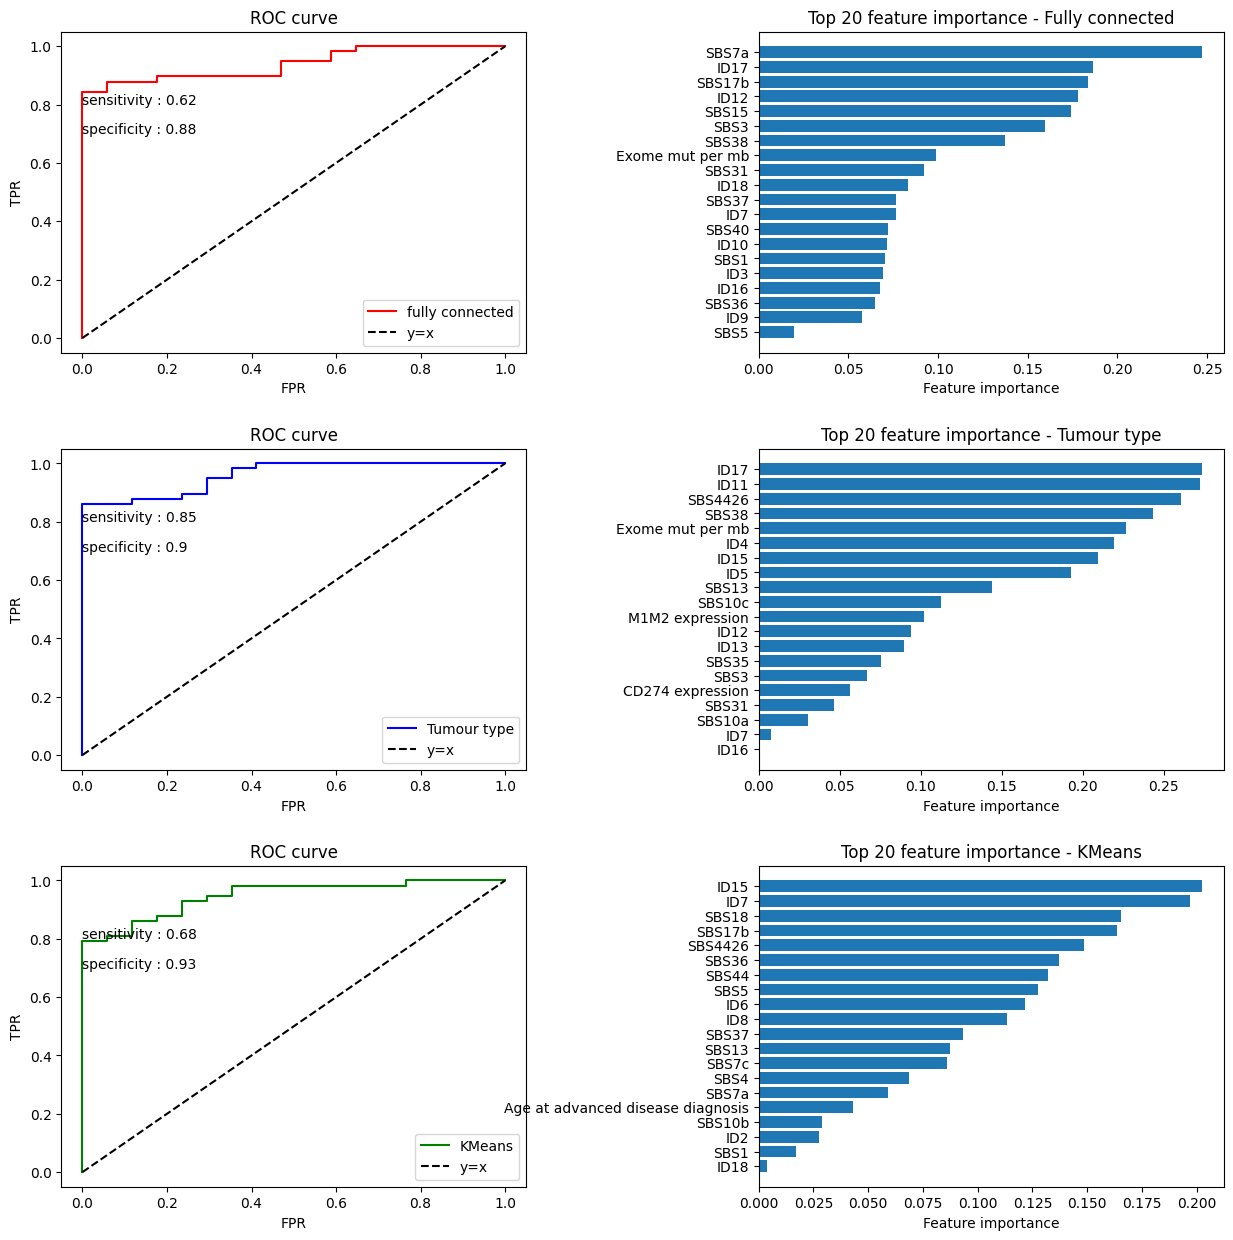

In [14]:
fig, ax = plt.subplots(3,2,figsize=(15,15))
x = np.linspace(0,1,100)

# Fully connected
# ROC curve
ax[0,0].plot(fpr_fc, tpr_fc, color='red',label='fully connected')
ax[0,0].plot(x,x,linestyle='--',color='black',label='y=x')
ax[0,0].set_xlabel('FPR')
ax[0,0].set_ylabel('TPR')
ax[0,0].set_title('ROC curve')
ax[0,0].text(0,0.8,f"sensitivity : {sensitivity_fc}")
ax[0,0].text(0,0.7,f"specificity : {specificity_fc}")
ax[0,0].legend()

# Feature importance
ax[0,1].barh(features_name_sorted_fc[:20],features_importance_sorted_fc[:20])
ax[0,1].set_xlabel("Feature importance")
ax[0,1].set_title("Top 20 feature importance - Fully connected")

# Tumour type
# ROC curve
ax[1,0].plot(fpr_tumour_type, tpr_tumour_type, color='blue',label='Tumour type')
ax[1,0].plot(x,x,linestyle='--',color='black',label='y=x')
ax[1,0].set_xlabel('FPR')
ax[1,0].set_ylabel('TPR')
ax[1,0].set_title('ROC curve')
ax[1,0].text(0,0.8,f"sensitivity : {sensitivity_tumour_type}")
ax[1,0].text(0,0.7,f"specificity : {specificity_tumour_type}")
ax[1,0].legend()

# Feature importance
ax[1,1].barh(features_name_sorted_tumour_type[0:20],features_importance_sorted_tumour_type[0:20])
ax[1,1].set_xlabel("Feature importance")
ax[1,1].set_title("Top 20 feature importance - Tumour type")

# KMeans
# ROC curve
ax[2,0].plot(fpr_kmeans, tpr_kmeans, color='green',label='KMeans')
ax[2,0].plot(x,x,linestyle='--',color='black',label='y=x')
ax[2,0].set_xlabel('FPR')
ax[2,0].set_ylabel('TPR')
ax[2,0].set_title('ROC curve')
ax[2,0].text(0,0.8,f"sensitivity : {sensitivity_kmeans}")
ax[2,0].text(0,0.7,f"specificity : {specificity_kmeans}")
ax[2,0].legend()

# Feature importance
ax[2,1].barh(features_name_sorted_kmeans[0:20],features_importance_sorted_kmeans[0:20])
ax[2,1].set_xlabel("Feature importance")
ax[2,1].set_title("Top 20 feature importance - KMeans")

plt.subplots_adjust(hspace=0.3, wspace=0.5)

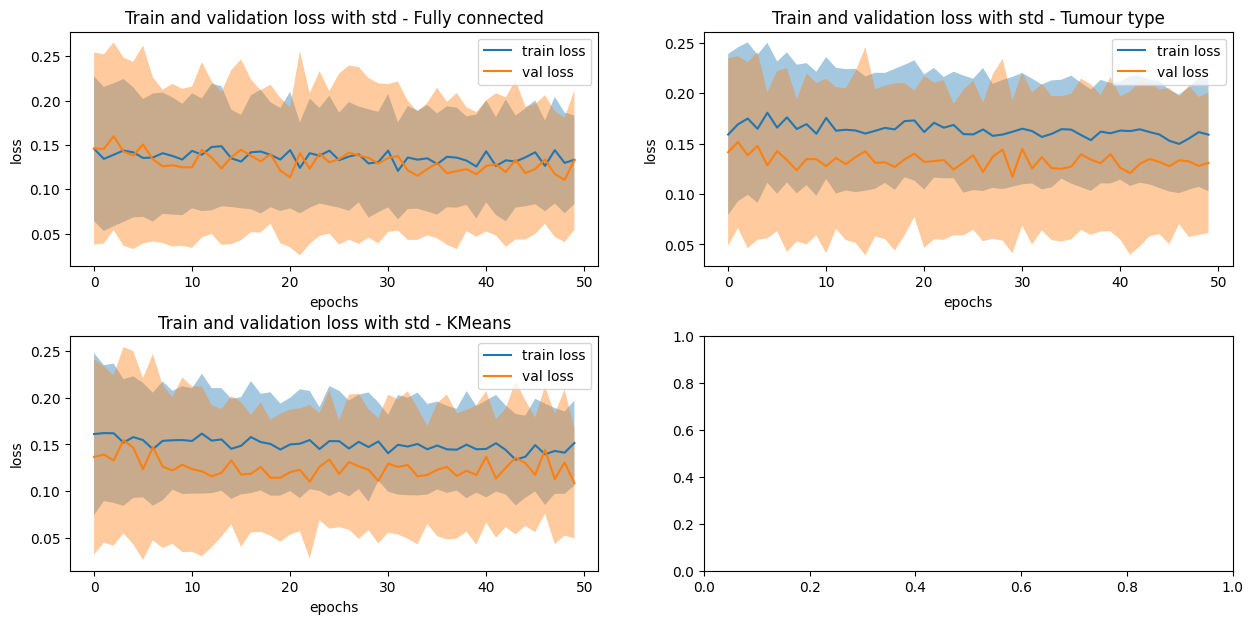

In [15]:
epochs = [k for k in range(n_epochs)]

fig, ax = plt.subplots(2,2,figsize=(15,7))

# Fully connected :
ax[0,0].plot(epochs, train_loss_fc,label='train loss')
ax[0,0].fill_between(epochs, train_loss_fc-std_train_loss_fc, train_loss_fc+std_train_loss_fc, alpha=0.4)
ax[0,0].plot(epochs, val_loss_fc,label='val loss')
ax[0,0].fill_between(epochs, val_loss_fc-std_val_loss_fc, val_loss_fc+std_val_loss_fc,alpha=0.4)
ax[0,0].set_xlabel('epochs')
ax[0,0].set_ylabel('loss')
ax[0,0].set_title('Train and validation loss with std - Fully connected')
ax[0,0].legend()

# Tumour type :
ax[0,1].plot(epochs, train_loss_tumour_type,label='train loss')
ax[0,1].fill_between(epochs, train_loss_tumour_type-std_train_loss_tumour_type, train_loss_tumour_type+std_train_loss_tumour_type, alpha=0.4)
ax[0,1].plot(epochs, val_loss_tumour_type,label='val loss')
ax[0,1].fill_between(epochs, val_loss_tumour_type-std_val_loss_tumour_type, val_loss_tumour_type+std_val_loss_tumour_type,alpha=0.4)
ax[0,1].set_xlabel('epochs')
ax[0,1].set_ylabel('loss')
ax[0,1].set_title('Train and validation loss with std - Tumour type')
ax[0,1].legend()

# KMeans :
ax[1,0].plot(epochs, train_loss_kmeans,label='train loss')
ax[1,0].fill_between(epochs, train_loss_kmeans-std_train_loss_kmeans, train_loss_kmeans+std_train_loss_kmeans, alpha=0.4)
ax[1,0].plot(epochs, val_loss_kmeans,label='val loss')
ax[1,0].fill_between(epochs, val_loss_kmeans-std_val_loss_kmeans, val_loss_kmeans+std_val_loss_kmeans,alpha=0.4)
ax[1,0].set_xlabel('epochs')
ax[1,0].set_ylabel('loss')
ax[1,0].set_title('Train and validation loss with std - KMeans')
ax[1,0].legend()

plt.subplots_adjust(hspace=0.3)